# LOAD Modules

In [1]:
%matplotlib inline
#%matplotlib widget
%load_ext autoreload
%autoreload 2


import numpy as np
from visualisations import eeg_sample_plot, events_distribution_plot
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader
from datasets import ChannelsVoltageDataset
from neural_nets.nn_models_getter import get_nn_model
from optimizers import get_optimizer
from utils_train import fit, test, plot_all_metrics, plot_val_metrics
from configs import configs_ozhan, configs_tim, configs_joaquin
from data_loader_creation import get_dataloader_objects
from classification_results import results_storer



# Select the configuration

In [2]:
""" USER: SELECT THE CONFIGURATION YOU NEED """
#myList = configs_tim.list_of_configs
#myList = configs_joaquin.list_of_configs
myList = configs_ozhan.list_of_configs

# Train

ConvNet3D_Adam 
-------------------------

Data is being loaded using MNE...
We are not on the cluster...


100%|██████████| 7/7 [00:14<00:00,  2.38s/it]


3158 matching events found
Applying baseline correction (mode: mean)
...data loading with MNE was finished. 

cuda will be used for training of this model.
You have 2 GPUs for training!
Learning Rate:  0.001
Epoch 1/50: train_loss: 7.2303, train_accuracy: 12.6320, val_loss: 2.2888, val_accuracy: 11.5789
Epoch 2/50: train_loss: 3.1949, train_accuracy: 16.1908, val_loss: 2.1327, val_accuracy: 15.0877
Epoch 3/50: train_loss: 2.5489, train_accuracy: 16.5819, val_loss: 2.1687, val_accuracy: 17.8947
Epoch 4/50: train_loss: 2.6343, train_accuracy: 19.1240, val_loss: 2.0390, val_accuracy: 20.7018
Epoch 5/50: train_loss: 2.3673, train_accuracy: 19.8670, val_loss: 2.0461, val_accuracy: 15.7895
Epoch 6/50: train_loss: 2.2153, train_accuracy: 22.5655, val_loss: 2.0363, val_accuracy: 19.2982
Epoch 7/50: train_loss: 2.2661, train_accuracy: 22.5655, val_loss: 2.0501, val_accuracy: 20.7018
Epoch 8/50: train_loss: 2.4347, train_accuracy: 22.0962, val_loss: 2.0829, val_accuracy: 23.5088
Epoch 9/50: trai

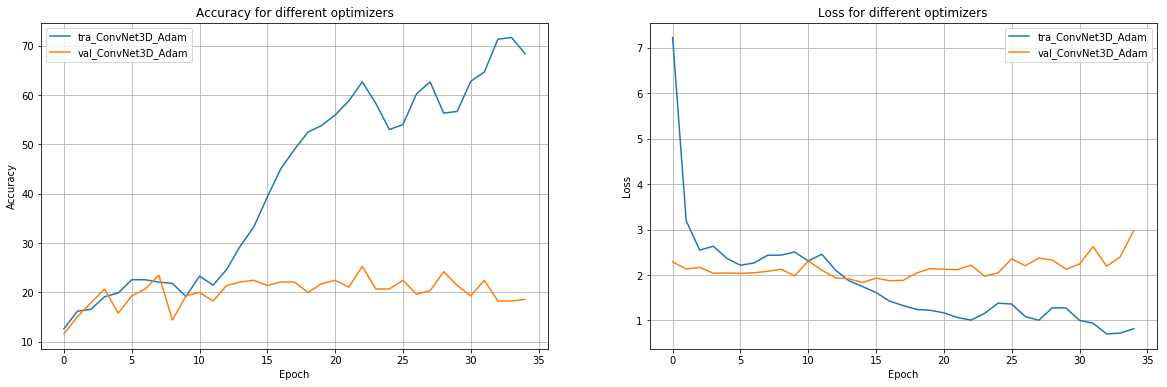

In [3]:
training_curves = {}

for my_cfg in myList:
    
    curve_name = my_cfg.nn_list[my_cfg.nn_selection_idx] + "_" + my_cfg.optimizer_list[my_cfg.optimizer_selection_idx]
    print(curve_name,"\n-------------------------\n", flush=True)
    
    """ PREPARE DATALOADERS """
    train_dl, val_dl, test_dl, input_dimension_, output_dimension_ = get_dataloader_objects(my_cfg)


    """CLASSIFICATION"""
    # Get the model
    model_untrained = get_nn_model(my_cfg.nn_list[my_cfg.nn_selection_idx], input_dimension=input_dimension_,
                                   output_dimension=output_dimension_)

    # Get the optimizer
    optimizer = get_optimizer(my_cfg.optimizer_list[my_cfg.optimizer_selection_idx], my_cfg.learning_rate,
                              model_untrained.parameters(), my_cfg.momentum, my_cfg.weight_decay)

    # Train and show validation loss
    train_losses, train_accuracies, val_losses, val_accuracies, model_trained, time_spent_for_training_s =\
        fit(train_dl, val_dl, model_untrained, optimizer, my_cfg.loss_fn, my_cfg.num_of_epochs, apply_early_stopping = my_cfg.use_early_stopping, estop_patience=my_cfg.es_patience)
    
    
    curves = train_losses, train_accuracies, val_losses, val_accuracies, model_trained, time_spent_for_training_s
    
    
    training_curves[curve_name] = curves
    
    # Test the net
    test_loss, test_accuracy = test(model_trained, test_dl, my_cfg.loss_fn, print_loss=True)

    # Store the results
    results_storer.store_results(my_cfg, model_trained, optimizer, test_loss, test_accuracy, train_losses,
                                 train_accuracies, time_spent_for_training_s, val_losses, val_accuracies)


plot_all_metrics(training_curves)